<a href="https://colab.research.google.com/github/itsmeeeeeee/MML/blob/main/MMF_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#(MMF) Multimodal Fusion Model (without self-attention) and RNN Classifier

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from PIL import Image, ImageFile

import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import torch

# Load labels from CSV
file_path_labels = "/content/drive/MyDrive/MultimodalNLP/projekt/data/labels.csv"
labeled_data = pd.read_csv(file_path_labels)
labels = labeled_data['overall_sentiment'].values

# Define your existing mapping
label_mapping = {
    "very_negative": 0,
    "negative": 0,
    "positive": 1,
    "very_positive": 1
}

# Get valid indices for labels that exist in the mapping
valid_indices = [i for i, label in enumerate(labels) if label in label_mapping]
filtered_labels = [labels[i] for i in valid_indices]

# Apply the mapping to convert filtered text labels to numeric labels
numeric_labels = np.array([label_mapping[label] for label in filtered_labels])

# Convert labels to a torch tensor
numeric_labels = torch.tensor(numeric_labels, dtype=torch.long)
print("numeric labels:", numeric_labels.shape)

# Load image features
file_path_im = "/content/drive/MyDrive/MultimodalNLP/projekt/features_data/image_features_restnet.npy"
image_features = np.load(file_path_im)

# Load text features
file_path_emb = "/content/drive/MyDrive/MultimodalNLP/projekt/features_data/text_features_bert.npy"
text_features = np.load(file_path_emb)

# Filter image and text features using valid indices
filtered_image_features = torch.tensor(image_features[valid_indices], dtype=torch.float32)
filtered_text_features = torch.tensor(text_features[valid_indices], dtype=torch.float32)

print("Filtered Image features:", filtered_image_features.shape)
print("Filtered Text features:", filtered_text_features.shape)


numeric labels: torch.Size([4791])
Filtered Image features: torch.Size([4791, 1000])
Filtered Text features: torch.Size([4791, 768])


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


"""
Split the initial dataset into training and preliminary testing sets.
20% of the data is reserved for preliminary testing, and 80% is used for training.
"""
train_text, prelim_test_text, train_image, prelim_test_image, train_labels, prelim_test_labels = train_test_split(
    filtered_text_features, filtered_image_features, numeric_labels, test_size=0.2, random_state=42
)

"""
Further split the preliminary testing data into validation and final test sets.
40% of the preliminary test data is used for validation and 60% for the final testing.
"""
val_text, test_text, val_image, test_image, val_labels, test_labels = train_test_split(
    prelim_test_text, prelim_test_image, prelim_test_labels, test_size=0.6, random_state=42
)

In [9]:
from torch.utils.data import DataLoader, TensorDataset

# DataLoaders für Training, Validierung und Test
train_dataset = TensorDataset(train_text, train_image, train_labels)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(val_text, val_image, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(test_text, test_image, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(Classifier_RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, num_classes)  # Unidirectional RNN

    def forward(self, x):
        # Initialize the hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(x.device)
        # Process inputs through the RNN
        out, _ = self.rnn(x, h0)
        # Use the output from the last timestep
        out = self.fc(out[:, -1, :])
        return out

class MultimodalFusionRNNClassifier(nn.Module):
    def __init__(self, text_dim, image_dim, hidden_dim, rnn_hidden_dim, num_classes):
        super(MultimodalFusionRNNClassifier, self).__init__()
        self.text_model = nn.Linear(text_dim, hidden_dim)
        self.image_model = nn.Linear(image_dim, hidden_dim)
        # RNN Classifier
        self.classifier = Classifier_RNN(hidden_dim * 2, rnn_hidden_dim, num_layers=2, num_classes=num_classes)

    def forward(self, text_features, image_features):
        # Process text and image features directly through their respective models
        text_features = self.text_model(text_features)
        image_features = self.image_model(image_features)
        # Combine the text and image features
        combined_features = torch.cat([text_features, image_features], dim=1)
        combined_features = combined_features.unsqueeze(1)  # Adding a sequence dimension for RNN
        # Classification
        output = self.classifier(combined_features)
        return output


In [11]:
"""
Training and validation loop for a Multimodal Fusion Classifier.
The code for the loop structure is adapted from Sebastian Raschka's guide on training loops in PyTorch:
https://sebastianraschka.com/faq/docs/training-loop-in-pytorch.html

Early stopping implementation inspired by: https://keras.io/api/callbacks/early_stopping/
"""


import torch
import numpy as np

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler, patience=10):
    trigger_times = 0  # Zähler für die Anzahl der Male, bei denen sich der Validierungsverlust nicht verbessert hat
    best_val_loss = float('inf')  # Initialisierung des besten Validierungsverlusts
    best_model = None  # Zum Speichern des besten Modellzustands

    for epoch in range(epochs):
        model.train()  # Setze das Modell in den Trainingsmodus
        total_train_loss = 0
        for texts, images, labels in train_loader:
            optimizer.zero_grad()  # Setze Gradienten auf Null für einen neuen Optimierungsschritt
            outputs = model(texts, images)
            loss = criterion(outputs, labels)  # Berechne den Verlust
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()  # Akkumuliere Verlust über das Epoch

        model.eval()  # Setze das Modell in den Evaluierungsmodus
        total_val_loss = 0
        with torch.no_grad():
            for texts, images, labels in val_loader:
                outputs = model(texts, images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        average_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}: Training Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f}')

        scheduler.step(average_val_loss)

        # Aktualisiere den Trigger-Zähler und überprüfe das Early Stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model = model.state_dict()  # Speichere den besten Modellzustand
            trigger_times = 0  # Setze den Trigger-Zähler zurück, da wir einen neuen Bestwert gefunden haben
        else:
            trigger_times += 1  # Inkrementiere den Trigger-Zähler
            if trigger_times >= patience:
                print('Early stopping triggered!')
                break

    # Lade den besten Modellzustand in das Modell und gebe das Modell zurück
    if best_model:
        model.load_state_dict(best_model)
    return model

# Model aufruf für die Funktion
model = MultimodalFusionRNNClassifier(text_dim=768, image_dim=1000, hidden_dim=128, rnn_hidden_dim=256, num_classes=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

best_model_rnn = train_model(model, train_loader, val_loader, 50, optimizer, criterion, scheduler, patience=10)


Epoch 1: Training Loss: 0.4164 | Validation Loss: 0.4029
Epoch 2: Training Loss: 0.4067 | Validation Loss: 0.3994
Epoch 3: Training Loss: 0.4026 | Validation Loss: 0.3928
Epoch 4: Training Loss: 0.3954 | Validation Loss: 0.4001
Epoch 5: Training Loss: 0.3924 | Validation Loss: 0.3979
Epoch 6: Training Loss: 0.3906 | Validation Loss: 0.3982
Epoch 7: Training Loss: 0.3915 | Validation Loss: 0.4019
Epoch 8: Training Loss: 0.3822 | Validation Loss: 0.4173
Epoch 9: Training Loss: 0.3773 | Validation Loss: 0.3967
Epoch 10: Training Loss: 0.3755 | Validation Loss: 0.4136
Epoch 11: Training Loss: 0.3685 | Validation Loss: 0.3993
Epoch 12: Training Loss: 0.3613 | Validation Loss: 0.4309
Epoch 13: Training Loss: 0.3584 | Validation Loss: 0.4236
Early stopping triggered!


In [12]:
"""
Code is based on guidance from:
- https://machinelearningmodels.org/evaluating-the-accuracy-score-of-your-machine-learning-model/
- https://scikit-learn.org/stable/modules/model_evaluation.html#

"""

import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model, loader):
    model.eval()
    all_outputs = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Deaktiviere die Gradientenberechnung
        for texts, images, labels in loader:
            outputs = model(texts, images)
            _, predicted = torch.max(outputs.data, 1)
            all_outputs.append(outputs.cpu().numpy())
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Berechne Metriken mit 'macro' Durchschnitt
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro')
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1 = f1_score(all_labels, all_predictions, average='macro')
    test_conf_matrix = confusion_matrix(all_labels, all_predictions)

    print("Test Accuracy:", test_accuracy)
    print("Precision (Macro):", test_precision)
    print("Recall (Macro):", test_recall)
    print("F1 Score (Macro):", test_f1)
    return test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix

test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(best_model_rnn, test_loader)


Test Accuracy: 0.8819444444444444
Precision (Macro): 0.49113475177304966
Recall (Macro): 0.49800292903741183
F1 Score (Macro): 0.48286242408238716


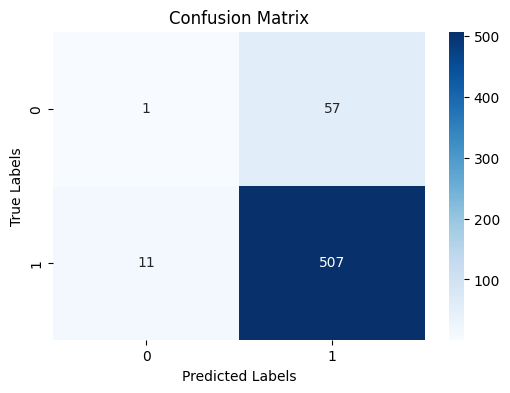

In [13]:
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()